**Note:**
The provided code is to be executed in a controlled virtual enviornment via 
installation of specifc versions of libraries to any avoid any conflicts or dependency issues.

# **Boolean Question Generation using T5 small trained on BoolQ Dataset**

# Installing Dependencies:

In [1]:
!pip install transformers
!pip install torchinfo
!pip install torch
!pip install datasets
!pip install matplotlib
!pip install tqdm
!pip install evaluate
!pip install pytorch-lightning
!pip install rouge-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=65762689d422b3a3a8f78310261a71c5b1a9bea1702c9da93bfc9ad3770e8434
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


# Including Libraries:

In [2]:
import time
import torch
import evaluate 
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchinfo import summary
from tabulate import tabulate
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW, T5Config

# Data Loading and Pre Processing:

Sample where answer is True:
question      do iran and afghanistan speak the same language
answer                                                   True
passage     Persian (/ˈpɜːrʒən, -ʃən/), also known by its ...
Name: 0, dtype: object

Sample where answer is False:
question           is elder scrolls online the same as skyrim
answer                                                  False
passage     As with other games in The Elder Scrolls serie...
Name: 4, dtype: object


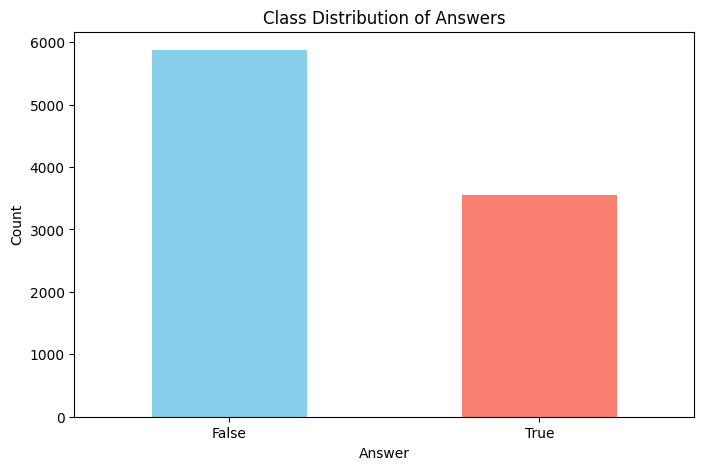


Class Imbalance Check:
Total Samples: 9427
True Samples: 5874 (62.31%)
False Samples: 3553 (37.69%)


In [3]:
# File paths
train_path = "../input/unlock-logical-thinking-with-the-boolq-dataset/train.csv"

# Load the train dataset
train_df = pd.read_csv(train_path)

# Step 1: Show one sample for each class
print("Sample where answer is True:")
print(train_df[train_df['answer'] == True].iloc[0])

print("\nSample where answer is False:")
print(train_df[train_df['answer'] == False].iloc[0])

# Step 2: Show data distribution for each class
class_distribution = train_df['answer'].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Class Distribution of Answers")
plt.xlabel("Answer")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0)
plt.show()

# Step 3: Check for class imbalances
total = len(train_df)
true_count = class_distribution[True]
false_count = class_distribution[False]

print("\nClass Imbalance Check:")
print(f"Total Samples: {total}")
print(f"True Samples: {true_count} ({(true_count / total) * 100:.2f}%)")
print(f"False Samples: {false_count} ({(false_count / total) * 100:.2f}%)")

In [11]:
# File paths
train_path = "../input/unlock-logical-thinking-with-the-boolq-dataset/train.csv"
validation_path = "../input/unlock-logical-thinking-with-the-boolq-dataset/validation.csv"

# Step 1: Load the data
train_df = pd.read_csv(train_path)
validation_df = pd.read_csv(validation_path)

# Step 2: Preprocess the data
def preprocess_data(df):
    # Clean text fields
    df['question'] = df['question'].str.strip()
    df['passage'] = df['passage'].str.strip()
    # Handle missing values
    df.dropna(subset=['question', 'passage'], inplace=True)
    return df

train_df = preprocess_data(train_df)
validation_df = preprocess_data(validation_df)

# Step 3: Prepare for T5 input format
def prepare_t5_format(df):
    # Use the passage as context and the question as target
    df['input_text'] = "Context: " + df['passage']
    df['target_text'] = df['question']  # The target is now the question
    return df[['input_text', 'target_text']]

train_df = prepare_t5_format(train_df)
validation_df = prepare_t5_format(validation_df)

# Step 4: Sample data (Optional)
sample_train = train_df.sample(5, random_state=42)  # Small sample for debugging
sample_validation = validation_df.sample(5, random_state=42)

print("Sample Training Data:")
print(sample_train.head())

print("\nSample Validation Data:")
print(sample_validation.head())

Sample Training Data:
                                             input_text  \
8681  Context: Filming took place from February to J...   
2362  Context: The home field curse affects the host...   
6232  Context: Radar jammers are not allowed under f...   
1318  Context: Chitty Chitty Bang Bang is a 1968 Bri...   
543   Context: The term ``Grand Slam'' was first app...   

                                            target_text  
8681     did jurassic world fallen kingdom come out yet  
2362  has there ever been a host team in the super bowl  
6232      is it legal to have a radar detector in texas  
1318            is chitty chitty bang bang just a story  
543   has anyone won the grand slam in golf in one year  

Sample Validation Data:
                                             input_text  \
1644  Context: Travel to each of these altitude regi...   
134   Context: The Fate of the Furious premiered in ...   
411   Context: Flipper was a mascot for the Miami Do...   
203   Context:

# Fine-Tuning T5-small (128M)

In [5]:
# Load the model and tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Prepare dummy inputs
input_text = "Translate English to French: The house is beautiful."
input_ids = tokenizer.encode(input_text, return_tensors="pt")  # Encoder input

decoder_input_text = "La maison est belle."
decoder_input_ids = tokenizer.encode(decoder_input_text, return_tensors="pt")  # Decoder input

# Display the architecture summary
print(summary(model, input_data={"input_ids": input_ids, "decoder_input_ids": decoder_input_ids}, depth=3))

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Layer (type:depth-idx)                                  Output Shape              Param #
T5ForConditionalGeneration                              [1, 12, 512]              --
├─T5Stack: 1-1                                          [1, 12, 512]              35,330,816
├─T5Stack: 1-2                                          --                        (recursive)
│    └─Embedding: 2-1                                   [1, 12, 512]              16,449,536
├─T5Stack: 1-3                                          --                        (recursive)
│    └─Dropout: 2-2                                     [1, 12, 512]              --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─T5Block: 3-1                                [1, 12, 512]              3,147,008
│    │    └─T5Block: 3-2                                [1, 12, 512]              3,146,752
│    │    └─T5Block: 3-3                                [1, 12, 512]              3,146,752
│    

In [3]:
# Check if GPUs are available
if torch.cuda.is_available():
    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"GPUs are available. Number of GPUs: {num_gpus}")
    
    # Display GPU names
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
    # Set the device to the first GPU
    device = torch.device("cuda:0")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    # Default to CPU if no GPU is available
    device = torch.device("cpu")
    print("No GPUs available. Using CPU.")

GPUs are available. Number of GPUs: 2
GPU 0: Tesla T4
GPU 1: Tesla T4
Using GPU: Tesla T4


In [6]:
class BoolQDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, index):
        row = self.data.iloc[index]
        input_text = row['input_text']  # The context of the passage
        target_text = row['target_text']  # The question to be generated

        # Tokenize the input text (context)
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Tokenize the target text (question)
        labels = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Return input_ids, attention_mask for input text, and labels (target question)
        return {
            "input_ids": inputs.input_ids.squeeze(),
            "attention_mask": inputs.attention_mask.squeeze(),
            "labels": labels.input_ids.squeeze()
        }

In [ ]:
# To prevent unwanted warnings
warnings.filterwarnings("ignore")

# Initialize tokenizer and model
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Modify the model config to change dropout rate if needed
config = T5Config.from_pretrained(model_name)
config.dropout_rate = 0.1  # Adjust the dropout rate here (0.1 is typical)

# Initialize model with the modified config
model = T5ForConditionalGeneration.from_pretrained(model_name, config=config)

# Move the model to the selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define training parameters
epochs = 5
batch_size = 8
learning_rate = 5e-5
max_grad_norm = 1.0  # Gradient clipping threshold
patience = 2  # Early stopping patience
patience_counter = 0
best_val_loss = float('inf')

# Create DataLoader
train_dataset = BoolQDataset(train_df, tokenizer)
val_dataset = BoolQDataset(validation_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer with L2 regularization (weight decay)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Track metrics
train_losses = []
val_losses = []

print("Starting model training...\n")

# Training loop with early stopping and gradient clipping
for epoch in range(epochs):
    start_time = time.time()  # Record the start time of the epoch
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training phase
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        total_train_loss += loss.item()

    # Calculate training metrics
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            total_val_loss += loss.item()

    # Calculate validation metrics
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Calculate the time elapsed for the epoch
    time_elapsed = time.time() - start_time  # Calculate elapsed time
    print(f"Epoch {epoch + 1}/{epochs} completed in {time_elapsed:.2f}s")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter when validation loss improves
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

Starting model training...



Training Epoch 1: 100%|██████████| 100/100 [00:02<00:00, 45.79it/s, elapsed=610.37s, rate=0.16it/s, time_left=0.00s] 


Epoch 1/5 completed in 610.37s


Training Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 45.72it/s, elapsed=846.90s, rate=0.12it/s, time_left=0.00s] 


Epoch 2/5 completed in 846.90s


Training Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 45.63it/s, elapsed=709.77s, rate=0.14it/s, time_left=0.00s] 


Epoch 3/5 completed in 709.77s


Training Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 45.93it/s, elapsed=630.77s, rate=0.16it/s, time_left=0.00s] 


Epoch 4/5 completed in 630.77s


Training Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 45.88it/s, elapsed=607.81s, rate=0.16it/s, time_left=0.00s] 

Epoch 5/5 completed in 607.81s



Training Summary:
╒═════════╤══════════════╤════════════╤════════════╕
│   Epoch │   Train Loss │   Val Loss │   Time (s) │
╞═════════╪══════════════╪════════════╪════════════╡
│       1 │       1.0236 │     1.0131 │     610.37 │
├─────────┼──────────────┼────────────┼────────────┤
│       2 │       0.7951 │     0.872  │     846.9  │
├─────────┼──────────────┼────────────┼────────────┤
│       3 │       0.6331 │     0.6708 │     709.77 │
├─────────┼──────────────┼────────────┼────────────┤
│       4 │       0.477  │     0.4527 │     630.77 │
├─────────┼──────────────┼────────────┼────────────┤
│       5 │       0.2154 │     0.2892 │     607.81 │
╘═════════╧══════════════╧════════════╧════════════╛


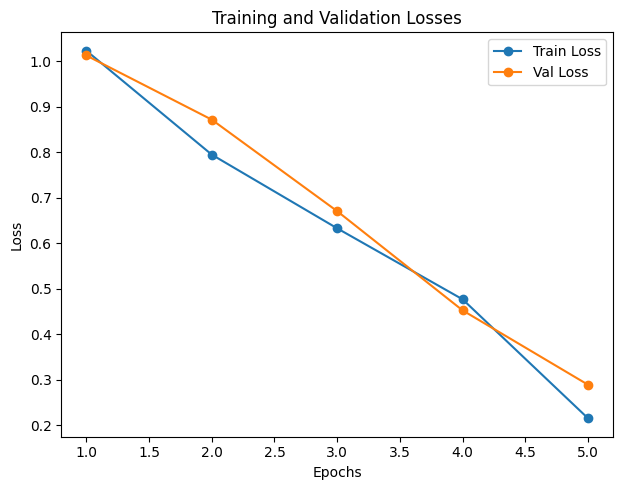

In [ ]:
# Prepare the table headers and rows
headers = ["Epoch", "Train Loss", "Val Loss", "Time (s)"]
table_data = [
    [epoch + 1, f"{train_losses[epoch]:.4f}", f"{val_losses[epoch]:.4f}", f"{epoch_times[epoch]:.2f}"]
    for epoch in range(epochs)
]

# Print the table after training
print("\nTraining Summary")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Optionally, plot loss and accuracy
import matplotlib.pyplot as plt

# Plotting loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [9]:
# Evaluation function
def evaluate(model, data_loader, tokenizer, device):
    model.eval()
    predictions, references = [], []
    for batch in tqdm(data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        
        predictions.extend([tokenizer.decode(output, skip_special_tokens=True) for output in outputs])
        references.extend([tokenizer.decode(label, skip_special_tokens=True) for label in labels])

    return predictions, references

# Load metrics
bleu = load_metric("bleu")
meteor = load_metric("meteor")
rouge = load_metric("rouge")

# Evaluate on validation set
preds, refs = evaluate(model, val_loader, tokenizer, device)

# Calculate BLEU, METEOR, and ROUGE
bleu_score = bleu.compute(predictions=preds, references=[[ref] for ref in refs])  # BLEU expects a list of references per prediction
meteor_score = meteor.compute(predictions=preds, references=refs)
rouge_score = rouge.compute(predictions=preds, references=refs)

# Prepare the results for the table
evaluation_metrics = [
    ["BLEU", f"{bleu_score['bleu']:.4f}"],
    ["METEOR", f"{meteor_score['meteor']:.4f}"],
    ["ROUGE-1", f"{rouge_score['rouge1'].fmeasure:.4f}"],
    ["ROUGE-2", f"{rouge_score['rouge2'].fmeasure:.4f}"],
    ["ROUGE-L", f"{rouge_score['rougeL'].fmeasure:.4f}"]
]

# Print the evaluation metrics as a table
print("\n--- Evaluation Metrics ---")
print(tabulate(evaluation_metrics, headers=["Metric", "Score"], tablefmt="fancy_grid"))


Evaluation Metrics:
╒════════╤══════════╤═══════════╤═══════════╤═══════════╕
│   BLEU │   METEOR │   ROUGE-1 │   ROUGE-2 │   ROUGE-L │
╞════════╪══════════╪═══════════╪═══════════╪═══════════╡
│ 0.3312 │   0.4373 │    0.4705 │    0.2746 │     0.394 │
╘════════╧══════════╧═══════════╧═══════════╧═══════════╛


In [10]:
# Save the trained model and tokenizer
model_save_path = "boolq_model"
tokenizer_save_path = "boolq_tokenizer"

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

('boolq_tokenizer/tokenizer_config.json',
 'boolq_tokenizer/special_tokens_map.json',
 'boolq_tokenizer/spiece.model',
 'boolq_tokenizer/added_tokens.json')

## Analysis

T5-small 128M (BoolQ)

Convergence:

    The model shows convergence as the validation loss consistently decreases across epochs. Both training and validation losses drop significantly from epoch 1 to 5.
    By epoch 5, the validation loss (0.2892) stabilizes, indicating that further training might not yield significant improvement.

Epochs for Convergence:

    Convergence is achieved in 5 epochs.

Overfitting or Underfitting:

    There’s no evidence of overfitting as the validation loss closely follows the training loss, maintaining a consistent gap.
    The model avoids underfitting, as it effectively minimizes both training and validation losses.

Solutions Applied:

    Early stopping at 5 epochs is a good choice to prevent overfitting and unnecessary training time.